In [1]:
import cv2
import easyocr
import pandas as pd
import re
import matplotlib.pyplot as plt
# Step 1: Image Preprocessing
def preprocess_image(image_path):
    # Load image using OpenCV
    image = cv2.imread(image_path)

    # Check if the image is loaded successfully
    if image is None:
        print(f"Error: Unable to load image from {image_path}")
        return None

    # Resize the image to a standard size
    image = cv2.resize(image, (800, 600))

    # Convert image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    plt.imshow(gray, cmap='gray')
    plt.title("Grayscale")
    plt.axis('off')
    plt.show()

    # Apply noise reduction techniques using Gaussian blur
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    plt.imshow(blurred, cmap='gray')
    plt.title("blurred")
    plt.axis('off')
    plt.show()

    # Apply median blur for additional noise reduction
    median_blurred = cv2.medianBlur(blurred, 5)
    plt.imshow(median_blurred, cmap='gray')
    plt.title("median_blurred")
    plt.axis('off')
    plt.show()

    # Improve the contrast of the image using histogram equalization
    equalized = cv2.equalizeHist(median_blurred)
    plt.imshow(equalized, cmap='gray')
    plt.title("Equalized")
    plt.axis('off')
    plt.show()

     # Apply adaptive thresholding
    thresholded = cv2.adaptiveThreshold(blurred, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)
    plt.imshow(thresholded, cmap='gray')
    plt.title("Thresholded")
    plt.axis('off')
    plt.show()

    # Use morphological operations to remove small noise and fill gaps
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))
    morphed = cv2.morphologyEx(thresholded, cv2.MORPH_CLOSE, kernel)

    # Find contours to isolate the ID card
    contours, _ = cv2.findContours(morphed.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Assuming the largest contour is the ID card
    if contours:
        largest_contour = max(contours, key=cv2.contourArea)
        x, y, w, h = cv2.boundingRect(largest_contour)
        cropped = image[y:y+h, x:x+w]
    else:
        cropped = image

    return cropped

In [2]:
# Step 2: Text Recognition with EasyOCR
def extract_text(image):
    # Use EasyOCR to extract text
    reader = easyocr.Reader(['en'])  # Initialize with English language
    result = reader.readtext(image)

    # Extract text from the result
    text = ' '.join([entry[1] for entry in result])

    return text, result


In [18]:
# Step 3: Structuring Output in DataFrame
def structure_text_to_dataframe(text_results):
    data = {
        'Field': [],
        'Value': []
    }

    full_text = ' '.join([entry[1] for entry in text_results])

    # Define patterns for fields using regular expressions
    field_patterns = {
        'Name': r'Name:\s*([\w\s]+)',
        'Position': r'Position:\s*([\w\s]+)',
        'Issued': r'Issued;?\s*([\d-]+)',
        'Expires': r'Expires:\s*([\d-]+)'
    }

    # Extract fields based on patterns
    for field, pattern in field_patterns.items():
        match = re.search(pattern, full_text)
        if match:
            value = match.group(1).strip()

            # Remove any subsequent field names from the value
            value = re.sub(r'\s*(?:Position|Issued).*', '', value)

            data['Field'].append(field)
            data['Value'].append(value)

    if not data['Field']:
        data['Field'].append('Full Text')
        data['Value'].append(full_text)

    df = pd.DataFrame(data)
    return df


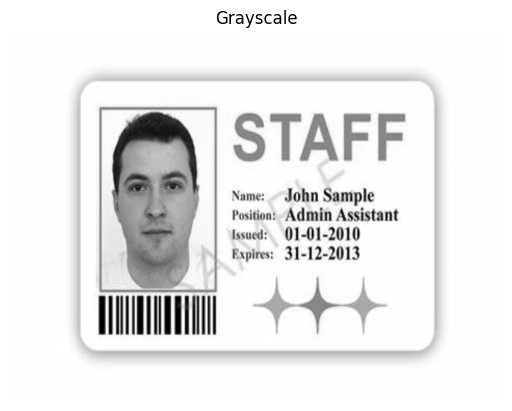

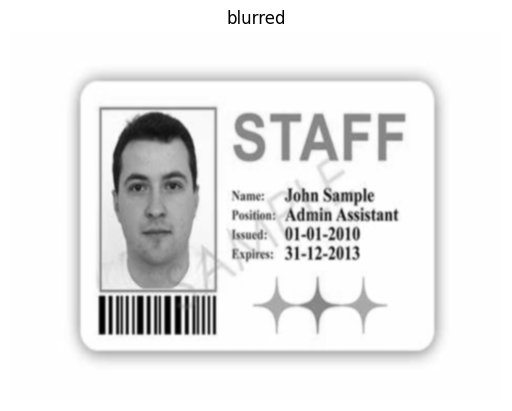

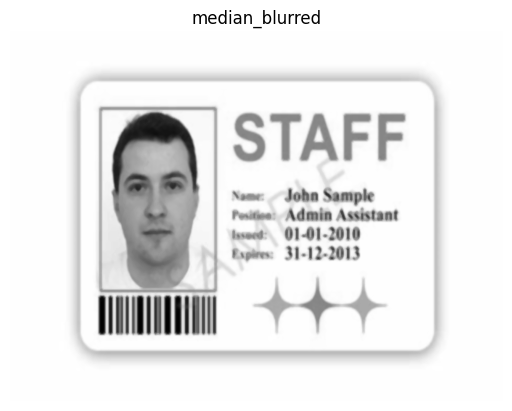

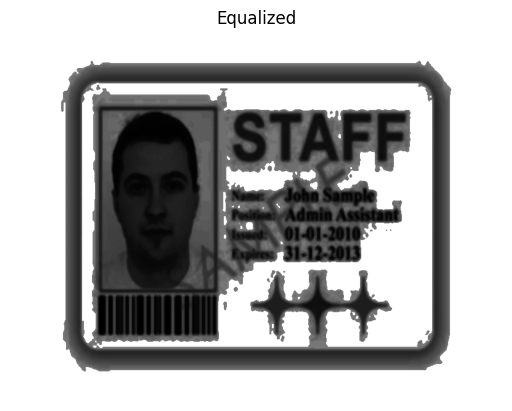

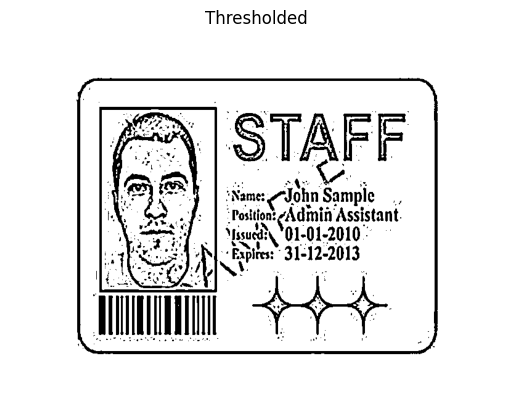

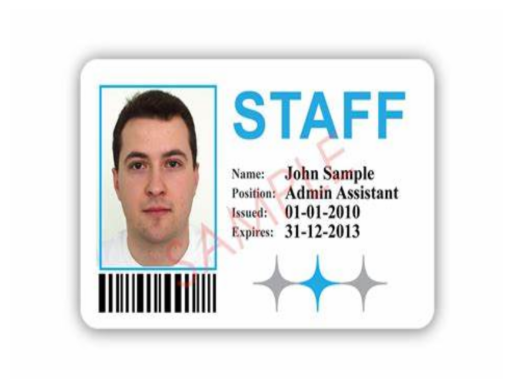

Extracted Text: STAFF Name: John Sample Position:   Admin Assistant Issued; 01-01-2010 Expires:   31-12-2013
      Field            Value
0      Name      John Sample
1  Position  Admin Assistant
2    Issued       01-01-2010
3   Expires       31-12-2013


In [19]:
# Test preprocessing
image_path = "sample_id_card.jpeg"
image = preprocess_image(image_path)
if image is not None:
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

    # Test OCR extraction
    text, text_results = extract_text(image)
    print("Extracted Text:", text)

    # Structure the text into a DataFrame
    df = structure_text_to_dataframe(text_results)
    print(df)

In [20]:

df

,Field,Value
0,Name,John Sample
1,Position,Admin Assistant
2,Issued,01-01-2010
3,Expires,31-12-2013
